## Data 604 Final Project

Using SimPy, write a process simulation that includes waiting time (discrete event simulation). You may use any topic of interest to you. Write the simulation and all of the following in Jupyter.

**1. State the problem and its significance.**

This project simulates a restaurant that offers 2 services to customers:

* **Self Service Buffet**    
    _The customer is provided with a plate and serves themselves to the buffet_.
    
    
* **Table Service**  
   _The customer is seated and their food is served to them by a waiter_.
   
There is one line for both services. The customer arrival rate is randomly generated using an exponential distribution with an arrival rate of ......


**2.  Provide a flow-chart model.**


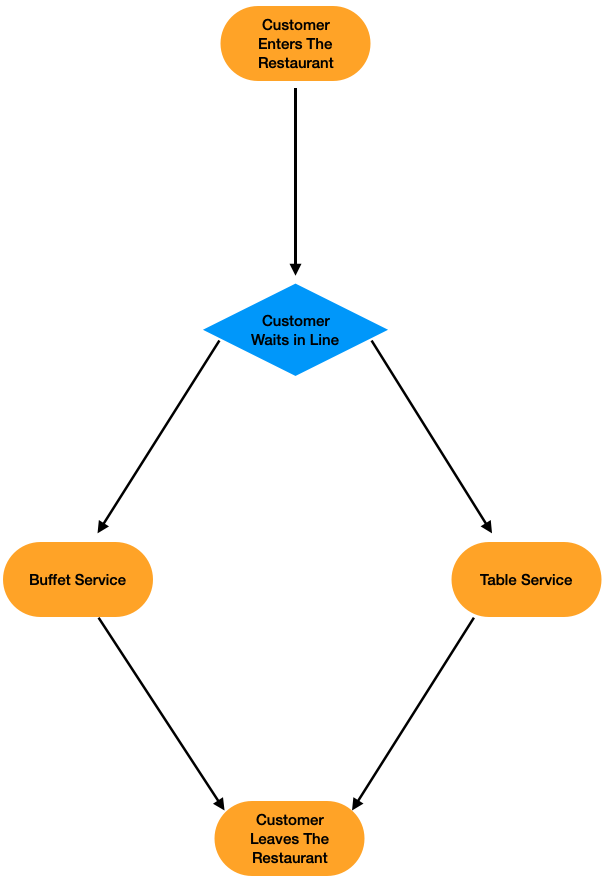

In [622]:
from IPython.display import Image
Image(filename = "figs/SimulationFlowChart.png", width = 400, height = 200)

**3.  Simulate the process for the appropriate number of iterations (justify).**


In [623]:
# Import the libraries required to perform the simulation.
import simpy
import numpy as np
import pandas as pd
import random

In [624]:
# Set seed and simulation time variables.
seed = 500

# Simulation time is representative of the restaurant's hours of business.
simulation_time = 12

# Instantiate a dataframe to contain the simulation results.
simulation_results = pd.DataFrame(columns = ['Customer', 'Service', 'Arrival Time',
                                             'Service Start Time', 'Service Stop Time'])


In [625]:
def generate_arrivals():
    """Generates customer arrivals at the restaurant.
    
    10 to 30 customers arrive at the restaurant every hour.
    """
    return np.random.exponential(60.0 / np.random.randint(10, 30))

In [626]:
def generate_buffet_service_time():
    """Generates service times for the buffet service."""
    return np.random.triangular(3, 4, 5)

In [627]:
def generate_table_service_time():
    """Generates service times for the table service."""
    return np.random.triangular(10, 15, 20)

In [628]:
def run_simulation(env, buffet, table_service):
    """ Runs the simulation.
    
    Parameters:
        env (object): Simpy environment object - manages the simulation time.
        buffet (int): Total capacity for the buffet service. 
        table_service (int): Total capacity for the table service. 
    """
    global current_hour
    customer = 0
    while True:
        service = np.random.choice(['Buffet', 'Table Service'], p = [0.85, 0.15])
        customer += 1
        yield env.timeout(generate_arrivals())
        env.process(generate_customer_report(env, customer, buffet, table_service, service))

In [629]:
def generate_customer_report(env, customer, buffet, table_service, Service):
    """ Generates the results of the simulation.
    
    Parameters:
        env (object): Simpy environment object - manages the simulation time.
        customer (int): Integer representing an individual customer.
        buffet (int): Total capacity for the buffet service. 
        table_service (int): Total capacity for the table service. 
        Service (string): Type of service (table service or buffet service).
    """
    global simulation_results

    with table_service.request() as request:
        arrival_time = env.now

        yield env.timeout(1/2)
        yield request

        service_start_time = env.now

        if Service == 'Table Service':
            yield env.timeout(generate_table_service_time())
        else:
            yield env.timeout(generate_buffet_service_time())

        service_stop_time = env.now 

        row = pd.DataFrame([['Customer_{}'.format(customer), Service, arrival_time, service_start_time,
                             service_stop_time]], columns = ['Customer', 'Service', 'Arrival Time',
                             'Service Start Time', 'Service Stop Time'])
       
        simulation_results = simulation_results.append(row, ignore_index = True, sort = False)

        # Calculate wait times.
        simulation_results['Service Time in Minutes'] = (simulation_results['Service Stop Time'] - simulation_results['Service Start Time'])
        simulation_results['Wait Time in Minutes'] = (simulation_results['Service Start Time'] - simulation_results['Arrival Time'])

In [630]:
def run_restaurant_model(simulation_runs, buffet_capacity, table_capacity):
    """ Runs the restaurant model.
    
    Parameters:
        env (int): An integer representing the amount of times the simulation should run. 
        buffet_capacity (int): Total capacity for the buffet service. 
        table_capacity (int): Total capacity for the table service. 

    Return:
        wait_times (Pandas Dataframe): A Pandas dataframe containing the model results.
    """
    global simulation_results
    
    # Initialize arrays to contain data.
    buffet_service = []
    table_service = []
    average_wait_time = []
    table_service_wait_time = []
    buffet_wait_time = []


    for count in range(simulation_runs):
        simulation_results = simulation_results[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        # Assign the buffet service as a resource.
        buffet = simpy.Resource(env, capacity = buffet_capacity)
        # Assign the table service as a resource.
        table = simpy.Resource(env, capacity = table_capacity)
        
        env.process(run_simulation(env, buffet, table))
        # Run for 12 hours.
        env.run(until = 12 * 60)
        
        
        buffet_service = simulation_results[simulation_results.Service.isin(['Buffet'])]
        table_service = simulation_results[simulation_results.Service.isin(['Table Service'])]

        # Calculate the average wait time for each service.
        average_wait = simulation_results['Wait Time in Minutes'].mean()
        average_wait_buffet = buffet_service['Wait Time in Minutes'].mean()
        average_wait_table = table_service['Wait Time in Minutes'].mean()
        
        # Append the results to the main wait time arrays.
        average_wait_time.append(average_wait)
        table_service_wait_time.append(average_wait_table)
        buffet_wait_time.append(average_wait_buffet)
        
    # Store the wait times in a dataframe.
    wait_times_dataframe = {"average_wait_time": average_wait_time,
                "table_service_wait_time": table_service_wait_time,
                "buffet_wait_time": buffet_wait_time}
    
    global wait_times
    # Store the wait time results in a Pandas' dataframe.
    wait_times = pd.DataFrame(wait_times_dataframe)

    # Return the results.
    return wait_times

In [631]:
# The restaurant is open 7 days a week so we run the model 30 times
# to reflect the number of working days in an average month.
np.random.seed(6758)
#wait_time_results = run_restaurant_model(30, 5, 1)
wait_time_results = run_restaurant_model(30, 10, 2)

**4. Justify the validity of the model and discuss how you verified it.**

Looking at the table of **wait time** results below, there is nothing to suggest that the wait times for table service are longer than those for the buffet service. Prior to running the simulation, I expected the wait times for table service to be longer given the fact that customers have to be seated by a waiter. However, from the below results, we can see that buffet service wait times are on occassions longer than table wait times (_for example, records 0, 8, and 15_). This may suggest that the there is an issue with the validity of the model.

In [632]:
wait_time_results

,average_wait_time,table_service_wait_time,buffet_wait_time
0,3.623579,2.644274,3.778532
1,5.804351,5.504667,5.854860
2,8.930303,7.594365,9.195831
3,5.036296,4.946997,5.046047
4,13.575331,13.538830,13.583981
5,11.922595,10.445570,12.191145
6,23.955898,21.165244,24.532737
7,9.553572,9.069637,9.635077
8,41.894952,35.562157,43.200683
9,7.027390,7.914537,6.912474


A Look at the **complete table of results** below, further confirms that the wait times for the buffet service are not shorter than table service wait times despite the fact that the _Service Time in Minutes_ for table service is higher than that of the buffet service. This may further suggest that there are issues with the model.  

In [633]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
simulation_results

,Customer,Service,Arrival Time,Service Start Time,Service Stop Time,Service Time in Minutes,Wait Time in Minutes
0,Customer_1,Buffet,0.695382,1.195382,5.670560,4.475178,0.500000
1,Customer_2,Buffet,4.530346,5.030346,9.349916,4.319570,0.500000
2,Customer_3,Buffet,5.641656,6.141656,10.227911,4.086255,0.500000
3,Customer_4,Buffet,12.109737,12.609737,16.548097,3.938360,0.500000
4,Customer_5,Buffet,13.628769,14.128769,18.294838,4.166070,0.500000
5,Customer_7,Buffet,14.185072,18.294838,21.789338,3.494500,4.109767
6,Customer_8,Buffet,15.735680,21.789338,26.579158,4.789820,6.053658
7,Customer_9,Buffet,21.544217,26.579158,30.200145,3.620988,5.034941
8,Customer_6,Table Service,13.878557,16.548097,33.272448,16.724350,2.669540
9,Customer_10,Buffet,25.680082,30.200145,34.474529,4.274383,4.520063


In [634]:
# Average wait time for each simuluation run.
print('Average Wait Time:', simulation_results['Wait Time in Minutes'].mean())

# Average wait time for the buffet service.
Buffet = simulation_results[simulation_results.Service.isin(['Buffet'])]
print('Average Buffet Service Wait Time:', Buffet['Wait Time in Minutes'].mean())

# Average wait time for the table service.
Table = simulation_results[simulation_results.Service.isin(['Table Service'])]
print('Average Table Service Wait Time:', Table['Wait Time in Minutes'].mean())


Average Wait Time: 8.53510937265631
Average Buffet Service Wait Time: 8.30865224529734
Average Table Service Wait Time: 9.589752565785219


**5. State your conclusions/findings from the model.** 

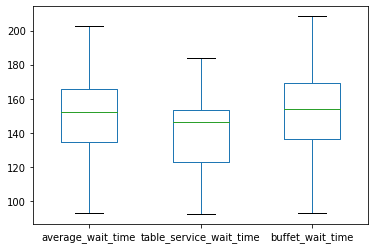

In [635]:
# Plot the wait time results.
box_plot = results.boxplot(grid = False, widths = 0.5)


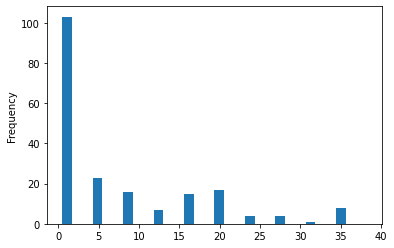

In [636]:
#histogram = results.plot.hist(width = 1.2)
histogram = simulation_results['Wait Time in Minutes'].plot.hist(width = 1.2)

#Out of 31 customers served, 2 had a wait time of over 10 mins, that is within acceptable range.

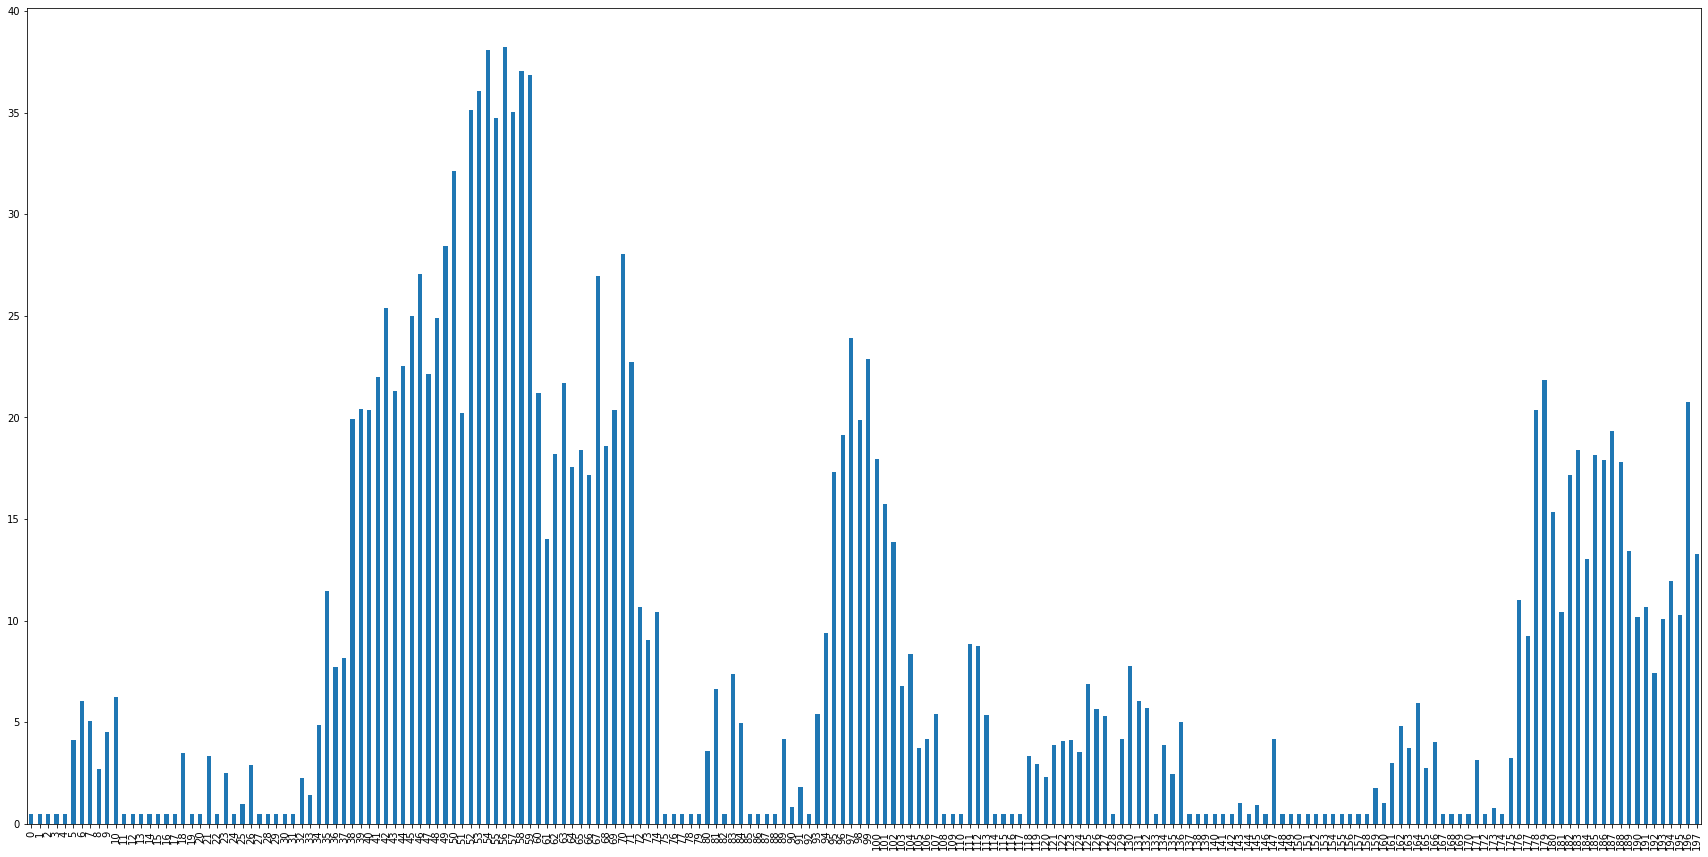

In [637]:
bargraph = simulation_results['Wait Time in Minutes'].plot.bar(figsize = (30, 15))

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 